## Example 06 - Container Transfer Hub

**Example description:** Example of a container transfer hub, where very large container vessels deliver containers, while smaller vessels take care of the distribution to the hinterland.

* [**0. Import required libraries:**](#0.-Import-required-libraries)<br>
* [**1. Define work method:**](#1.-Define-work-method)<br>
   * [**1.1 Sites:**](#1.1-Define-the-project-sites)<br>
   * [**1.2 Equipment:**](#1.2-Define-the-project-equipment)<br>
   * [**1.3 Activities:**](#1.3-Define-the-activity)<br>
* [**2. Run the simulation:**](#2.-Run-the-simulation)<br>
* [**3. Post processing:**](#3.-Postprocessing)<br>

## 0. Import required libraries

In [1]:
# package(s) related to time, space and id
import datetime, time
import platform

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy

# spatial libraries 
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import numpy as np
import pandas as pd

# digital twin package
import digital_twin.core as core
import digital_twin.model as model
import digital_twin.plot as plot

# Used for making the graph to visualize our problem
import networkx as nx

In [2]:
# Create simulation environment
simulation_start = datetime.datetime(2019, 1, 1)

my_env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
my_env.epoch = time.mktime(simulation_start.timetuple())

## 1. Define work method

### 1.1 Define the project sites
You can specify a project site object by entering mix-ins:

    core.Identifiable - enables you to give the object a name
    core.Log - enables you to log all discrete events in which the object is involved
    core.Locatable - enables you to add coordinates to extract distance information and visualize
    core.HasContainer - enables you to add information on the material available at the site
    core.HasResource - enables you to add information on serving equipment
    core.HasWeather - enables you to add weather conditions

#### Create objects and specify the properties for sites you wish to create

In [3]:
def connect_sites_with_path(data_from_site, data_to_site, data_node, path):
    Nodes = []
    Edges = []
    Site = type('Site', (core.Identifiable, # Give it a name
             core.Log,          # Allow logging of all discrete events
             core.Locatable,    # Add coordinates to extract distance information and visualize
             core.HasContainer, # Add information on the material available at the site
             core.HasResource), # Add information on serving equipment
    {})                         # The dictionary is empty because the site type is generic

    Node = type('Node', (core.Identifiable, # Give it a name
             core.Log,          # Allow logging of all discrete events
             core.Locatable),   # Add coordinates to extract distance information and visualize
    {})                         # The dictionary is empty because the site type is generic

    for i, j in enumerate(path):
        if i == 0:
            data_from_site["geometry"]=shapely.geometry.Point(path[i][0], path[i][1])
            Nodes.append(Site(**data_from_site))

        elif i == len(path) - 1:
            data_to_site["geometry"]=shapely.geometry.Point(path[i][0], path[i][1])
            Nodes.append(Site(**data_to_site))
            Edges.append([Nodes[i-1], Nodes[i]])
            
        else:
            data_node["geometry"]=shapely.geometry.Point(path[i][0], path[i][1])
            data_node["name"]='node-' + str(i)
            node = Node(**data_node)
            node.name = node.id
            Nodes.append(node)
            Edges.append([Nodes[i-1], Nodes[i]])
            
    return Nodes, Edges

In [4]:
data_from_site = {"env": my_env,                  # The simpy environment defined in the first cel
                  "name": "Origin locatie",       # The name of the site
                  "geometry": [],                 # The coordinates of the project site
                  "capacity": 10_000_000,         # The capacity of the site
                  "level": 10_000_000}            # The actual volume of the site

data_inter_site = {"env": my_env,                 # The simpy environment defined in the first cel
                "name": "Overslag locatie",       # The name of the site
                "geometry": [],                   # The coordinates of the project site
                "capacity": 10_000_000,           # The capacity of the site
                "level": 0,                       # The actual volume of the site (empty of course)
                "nr_resources": 2}

data_to_site = {"env": my_env,                    # The simpy environment defined in the first cel
                "name": "Destination locatie",    # The name of the site
                "geometry": [],                   # The coordinates of the project site
                "capacity": 10_000_000,           # The capacity of the site
                "level": 0}                       # The actual volume of the site (empty of course)

data_node = {"env": my_env,                      # The simpy environment defined in the first cel
                 "name": "Intermediate site",     # The name of the site
                 "geometry": []}                  # The coordinates of the project site


In [5]:
path_from_to_inter = [[0.4961956247618216,51.50367589686757],
                       [0.5025738662738322,51.49604982804586],
                       [0.5227880400306528,51.49310077851462],
                       [0.5816599472145456,51.4914450662929],
                       [0.7033497639228536,51.48775013590905],
                       [0.9213342585195417,51.49518188267707],
                       [1.205921256841014,51.56703658374334],
                       [1.37927621092955,51.65341304718244],
                       [2.084459657644391,52.04005347868334],
                       [2.366127315407969,52.14511989576717],
                       [2.688480477407984,52.19372273332205],
                       [2.939535440652905,52.19718741074821],
                       [3.341109553423358,52.17629339631259],
                       [3.592584199826665,52.12222705440335],
                       [3.794715309195611,52.07390793081763],
                       [3.910470529738688,52.03848643163826],
                       [3.970345540223303,52.02008209003584],
                       [4.031934564338546,51.99891078085604],
                       [4.059007112763931,51.98601180923669],
                       [4.073325806237193,51.98072466956628],
                       [4.083094893235839,51.97618275648908],
                       [4.088433542877061,51.97322005781426],
                       [4.090317076226691,51.96908908270685],
                       [4.088019473833288,51.96410572394782],
                       [4.085446006078913,51.9590587793433],
                       [4.084635741928757,51.95392943223551],
                       [4.083633414899001,51.95106594180597],
                       [4.078905919496756,51.95003563908778],
                       [4.073033873352547,51.94955417747328],
                       [4.068048285555426,51.94933505255866],
                       [4.064841994596411,51.94963274522105],
                       [4.067560378249368,51.95173269362142]]

In [6]:
# path_from_to_inter = [[0.4961956247618216,51.50367589686757],
#                        [0.5025738662738322,51.49604982804586],
#                        [4.064841994596411,51.94963274522105],
#                        [4.067560378249368,51.95173269362142]]

In [7]:
path_inter_to_destination = [[4.067560378249368,51.95173269362142],
                            [4.076820637063388,51.95330987222201],
                            [4.079712688631274,51.953446219582],
                            [4.083425060670932,51.95390297933297],
                            [4.085483449904752,51.95489780261229],
                            [4.086425210731035,51.95649433347911],
                            [4.087047731300368,51.96004684231188],
                            [4.088330721753446,51.9633482094768],
                            [4.09039781548441,51.96772136816238],
                            [4.092968441867448,51.96999758880575],
                            [4.092969797007648,51.97001855604434],
                            [4.095358900900368,51.97122684588547],
                            [4.098265390457938,51.97168483331319],
                            [4.100522582738943,51.9716044921872],
                            [4.104952016621184,51.97082323370393],
                            [4.106969064376984,51.9701732443181],
                            [4.11212610241485,51.96918215518502],
                            [4.115527897618638,51.96927862645877],
                            [4.119759282494724,51.96994491194637],
                            [4.120735501031532,51.9708189303758],
                            [4.121493527001445,51.97189406452166],
                            [4.123560651538227,51.97241789317135],
                            [4.123603726198266,51.97241843904959],
                            [4.127256062950561,51.97169226998802],
                            [4.132071369717247,51.9692772453104],
                            [4.16223267129274,51.95424601796267],
                            [4.189082800242008,51.94093430859656],
                            [4.207132604039932,51.93514335820377],
                            [4.220687795782876,51.92918978842068],
                            [4.227416861309566,51.92440552825687],
                            [4.230730286072008,51.91984839984131],
                            [4.235475403784726,51.9168646392894],
                            [4.240569013470141,51.91440957329543],
                            [4.249610884923765,51.91116037082725],
                            [4.25969214611073,51.90756693550011],
                            [4.268492241328062,51.90410297127595],
                            [4.274469667188424,51.90168552139975],
                            [4.28301081754686,51.89906894148864],
                            [4.291305306877453,51.89689875129605],
                            [4.305503018796861,51.89432164764471],
                            [4.31809375576814,51.8929833069486],
                            [4.332208883875859,51.89330355314834],
                            [4.345562538298311,51.89543229242783],
                            [4.356042563346907,51.89784807111106],
                            [4.361320463350369,51.89842048825951],
                            [4.370896566526032,51.89809394063443],
                            [4.380565139323275,51.89717011717858],
                            [4.393151412801199,51.89581538742945],
                            [4.403418933850478,51.89742871871072],
                            [4.411919037719847,51.8997472455142],
                            [4.423612313781257,51.90139531785889],
                            [4.439268026366565,51.90083199110271],
                            [4.449037995592223,51.89931760462949],
                            [4.461767614020076,51.89899818977116],
                            [4.474773140831829,51.90244636354545],
                            [4.482070795323829,51.90561747759247],
                            [4.487030748476483,51.91078399779754],
                            [4.492098300234863,51.91447559934962],
                            [4.497637202151587,51.91716380292601],
                            [4.504133201441627,51.91714383868787],
                            [4.510101621366531,51.91552590479486],
                            [4.513739062848849,51.91311565640532],
                            [4.515982476878834,51.90926080354506],
                            [4.517411708268972,51.90429039701775],
                            [4.522186973978228,51.90085359184045],
                            [4.527633272730036,51.89959232154308],
                            [4.533205356433858,51.90103901123491],
                            [4.547119922272424,51.90389815319988],
                            [4.555920039898471,51.90464541896166],
                            [4.566246838379273,51.90373868574678],
                            [4.574308721369038,51.90265020585922],
                            [4.580770710023609,51.90175368116945],
                            [4.586404529249966,51.89842953716524],
                            [4.590314594477423,51.89497472879613],
                            [4.597054420552245,51.89306391523745],
                            [4.603374751770295,51.89214079308947],
                            [4.611551716755134,51.89048423400467],
                            [4.619669882387685,51.88814231345802],
                            [4.624038918436531,51.88379905811727],
                            [4.627713881315099,51.87877126596626],
                            [4.631626627198553,51.87334936837566],
                            [4.635905647775802,51.86920603096677],
                            [4.64216545880663,51.86592487379189],
                            [4.64841594475981,51.86223810253749],
                            [4.651946318226335,51.85882215036123],
                            [4.655056077228421,51.85431704464076],
                            [4.658549006280516,51.85092161313503],
                            [4.663720310464568,51.84668379417203],
                            [4.668473234687003,51.84308201876836],
                            [4.672040492871687,51.84004061666239],
                            [4.672235910423009,51.8367062293061],
                            [4.671528932783917,51.83337574079015],
                            [4.669277919399506,51.82949222714719],
                            [4.670199703393161,51.82537182423186],
                            [4.673559552120016,51.82155690783971],
                            [4.680135603350573,51.82023793739657],
                            [4.687273441208006,51.82083581685784],
                            [4.696625285705443,51.82213397468308],
                            [4.708251626028501,51.82290063616291],
                            [4.717741366513386,51.82275120977883],
                            [4.733504291300051,51.82150673257545],
                            [4.745642026327013,51.82176898310094],
                            [4.757525115667258,51.81930783361474],
                            [4.765156822973169,51.81658065060491],
                            [4.77224975867407,51.81533638421544],
                            [4.781690532716773,51.81484342987568],
                            [4.789463450027254,51.81544328718915],
                            [4.796791309439379,51.81677806004002],
                            [4.807441094269487,51.81804324929072],
                            [4.815857905456644,51.8187414085792],
                            [4.827533117736644,51.81871673501277],
                            [4.843155905955978,51.81871424396314],
                            [4.856652763130526,51.81805038570205],
                            [4.868638749538699,51.81756264829223],
                            [4.882456189917511,51.81809947450498],
                            [4.899975527303077,51.82078552536477],
                            [4.911280754349767,51.82489324537378],
                            [4.921906597784968,51.82613601424819],
                            [4.932698073860953,51.82710631585912],
                            [4.941191710823151,51.8265982036505],
                            [4.949355884609769,51.82572252244409],
                            [4.958143493090537,51.82434451438033],
                            [4.966556398445936,51.82345976520273],
                            [4.978240366452679,51.82157864117246],
                            [4.987498167054545,51.82033482308396],
                            [5.000198867825329,51.8202077333635],
                            [5.012291812443531,51.82007708098652],
                            [5.019805133726956,51.81909960963222],
                            [5.029954111151898,51.81758977718439],
                            [5.040378825925553,51.81708591870648],
                            [5.049632999060512,51.81803432608763],
                            [5.058192310624607,51.82007911388263],
                            [5.068189125879625,51.82333435487994],
                            [5.077760950577357,51.82577415227986],
                            [5.08516960920468,51.82644973431204],
                            [5.094301041156042,51.82555516334745],
                            [5.102334272099371,51.8235504560227],
                            [5.111751119616674,51.82027443148616],
                            [5.121988725976527,51.81684099638534],
                            [5.131337073522175,51.81463945349422],
                            [5.138812542819055,51.81411026323648],
                            [5.147958189478768,51.81423135897111],
                            [5.157296121771515,51.81527545297399],
                            [5.167847197660103,51.81604688798863],
                            [5.176287019372346,51.81560794732032],
                            [5.183742217173723,51.81442881288278],
                            [5.191874864582373,51.81224355953395],
                            [5.204011191193192,51.81016945455846],
                            [5.215067968069485,51.81028837238208],
                            [5.224069283460519,51.81159246365836],
                            [5.231617091471959,51.8132636597709],
                            [5.240732694055823,51.81568245783155],
                            [5.250223255763977,51.81727712277183],
                            [5.259874191807863,51.81822667570454],
                            [5.271475102635193,51.81880848131871],
                            [5.283390220330146,51.8211671732013],
                            [5.298183428420488,51.82328499515426],
                            [5.308310357128098,51.82330355696522],
                            [5.319439185068386,51.82014601255953],
                            [5.328234889187014,51.81501088308405],
                            [5.33552319156547,51.80892295714031],
                            [5.344869041990828,51.80457573845603],
                            [5.357444888560695,51.80413173898008],
                            [5.366318851263614,51.8074767275679],
                            [5.373693704327169,51.81460135547123],
                            [5.387226592909375,51.82866856327106],
                            [5.399563297735734,51.83669611203315],
                            [5.409275792783115,51.84347424107042],
                            [5.413578146986855,51.84873503937268],
                            [5.416932517238118,51.85529844953433],
                            [5.421719519181458,51.86493532531011],
                            [5.426800457967684,51.87041449632006],
                            [5.432065262544104,51.87501318637114],
                            [5.438947863609536,51.88070591644556],
                            [5.446909704315964,51.88473221943546],
                            [5.456367203833493,51.88752557865974],
                            [5.467070245985532,51.88930779483466],
                            [5.477511940329958,51.88949934077544],
                            [5.486438318114752,51.88903299224701],
                            [5.496266048358698,51.88875397256585],
                            [5.504749878467248,51.88931686901948],
                            [5.517530304813214,51.89110045292324],
                            [5.532737093692632,51.89443827028928],
                            [5.546260614787153,51.89863323911392],
                            [5.557382345078372,51.90050757223898],
                            [5.565433531883439,51.90115979188721],
                            [5.579016069306584,51.90077581078447],
                            [5.591106692405168,51.89917491169804],
                            [5.602437384123209,51.89869734795168],
                            [5.613179538005744,51.8986886564679],
                            [5.622893693798725,51.89905574510674],
                            [5.638620717905121,51.89847634405258],
                            [5.652796915256921,51.89696165125128],
                            [5.664387048338215,51.89555150558807],
                            [5.676576896037854,51.89497720537521],
                            [5.688944318966057,51.89505275577271],
                            [5.699076037562671,51.89410681902976],
                            [5.71000317902572,51.89195879156682],
                            [5.718757214978709,51.88927155823234],
                            [5.727755131467125,51.88650705026279],
                            [5.737676553063986,51.88512078447754],
                            [5.746554555562565,51.88401108755011],
                            [5.758563925815176,51.88137012205462],
                            [5.769915386803762,51.87903921775698],
                            [5.78156180047936,51.87772596776766],
                            [5.790920258484098,51.87642142104163],
                            [5.798929793773409,51.87530466796605],
                            [5.808154973066939,51.87282302901447],
                            [5.815990818322954,51.87047873546578],
                            [5.822454756566935,51.86787083410703],
                            [5.826571631862523,51.86591435542805],
                            [5.830642316553229,51.86369601127469],
                            [5.831171742503569,51.86272173998423],
                            [5.830619709457634,51.86183419049677],
                            [5.830727947258836,51.86102575658615]]

In [8]:
# path_inter_to_destination = [[4.067560378249368,51.95173269362142],
#                             [4.076820637063388,51.95330987222201],
#                             [4.079712688631274,51.953446219582],
#                             [4.083425060670932,51.95390297933297],
#                             [5.830619709457634,51.86183419049677],
#                             [5.830727947258836,51.86102575658615]]

#### Finally create specific instances of the predefined objects with the specified properties

In [9]:
Nodes1, Edges1 = connect_sites_with_path(data_from_site, data_inter_site, data_node, path_from_to_inter)
Nodes2, Edges2 = connect_sites_with_path(data_inter_site, data_to_site, data_node, path_inter_to_destination)

#### Create graph

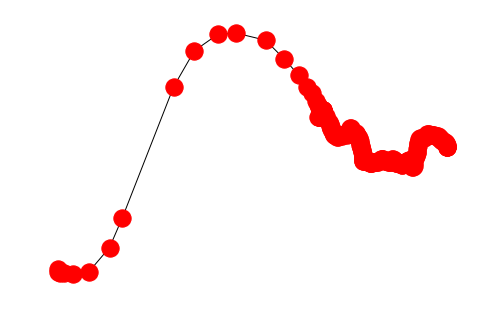

In [10]:
def add_path_to_graph(FG, positions, Nodes, Edges):
    
    for node in Nodes:
        #print(node.name)
        positions[node.name] = (node.geometry.x, node.geometry.y)
        FG.add_node(node.name, geometry = node.geometry)


    for edge in Edges:
        #print(edge[0].name + ' - ' + edge[1].name)
        FG.add_edge(edge[0].name, edge[1].name, weight = 1)

    return FG, positions

positions = {}
FG = nx.Graph()

FG, positions = add_path_to_graph(FG, positions, Nodes1, Edges1)
FG, positions = add_path_to_graph(FG, positions, Nodes2, Edges2)

nx.draw(FG, positions)

### 1.2 Define the project equipment
You can specify a vessel object by entering mix-ins:

    core.Identifiable - enables you to give the object a name
    core.Log - enables you to log all discrete events in which the object is involved
    core.ContainerDependentMovable - A moving container, so capacity and location
    core.Processor - Allow for loading and unloading
    core.HasResource - Add information on serving equipment
    core.HasDepthRestriction - Add information on depth restriction 

#### First create objects with the desired properties

In [11]:
# The generic class for an object that can move and transport (a TSHD for example)
TransportProcessingResource = type('TransportProcessingResource', 
                                   (core.Identifiable,              # Give it a name
                                    core.Log,                       # Allow logging of all discrete events
                                    core.ContainerDependentMovable, # A moving container, so capacity and location
                                    core.Processor,                 # Allow for loading and unloading
                                    core.HasResource,               # Add information on serving equipment
                                    core.HasSoil,                   # Add soil object, because it moves soil
                                    core.Routeable),                 # Initialize spill terms
                                   {})

#### Next specify the properties for vessel(s) you wish to create

In [12]:
# For more realistic simulation you might want to have speed dependent on the volume carried by the vessel
def compute_v_provider(v_empty, v_full):
    return lambda x: x * (v_full - v_empty) + v_empty

def compute_loading(rate):
    return lambda current_level, desired_level: (desired_level - current_level) / rate

def compute_unloading(rate):
    return lambda current_level, desired_level: (current_level - desired_level) / rate

In [13]:
# Large container vessel variables
data_container_large = {"env": my_env,                              # The simpy environment 
               "name": "Container large",                           # Name
               "geometry": Nodes1[-1].geometry,                     # It starts at the "from site"
               "loading_func": compute_loading(1.5),                # Loading rate
               "unloading_func": compute_unloading(1.5),            # Unloading rate
               "capacity": 20_000,                                  # Capacity of the container vessel - TEU
               "compute_v": compute_v_provider(5, 4.5)}             # Variable speed 

In [14]:
# Small container vessel variables
data_container_small = {"env": my_env,                              # The simpy environment 
               "name": "Container small",                           # Name
               "geometry": Nodes1[-1].geometry,                       # It starts at the "from site"
               "loading_func": compute_loading(1.5),                # Loading rate
               "unloading_func": compute_unloading(1.5),            # Unloading rate
               "capacity": 3_000,                                   # Capacity of the container vessel - TEU
               "compute_v": compute_v_provider(5, 4.5)}             # Variable speed 

#### Finally create specific instances of the predefined objects with the specified properties

In [15]:
# The simulation object
container_large = TransportProcessingResource(**data_container_large)
container_small = TransportProcessingResource(**data_container_small)

### 1.3 Define the activity

In [16]:
# Continuous simulation, stop after one year
stop_event = my_env.timeout(365 * 24 * 3600)   # Year in seconds

In [17]:
# Create activity
activity_1 = model.Activity(env = my_env,                   # The simpy environment defined in the first cel
                          name = "International transport", # We are moving soil
                          origin = Nodes1[0],               # We originate from the from_site
                          destination = Nodes1[-1],         # And therefore travel to the to_site
                          loader = container_large,         # The benefit of a TSHD, all steps can be done
                          mover = container_large,          # The benefit of a TSHD, all steps can be done
                          unloader = container_large,       # The benefit of a TSHD, all steps can be done
                          start_event = None,               # We can start right away
                          stop_event = stop_event)          # We stop the simulation after one year

In [18]:
# Create activity                      
activity_2 = model.Activity(env = my_env,                   # The simpy environment defined in the first cel
                          name = "Hinterland transport",    # We are moving soil
                          origin = Nodes1[-1],              # We originate from the from_site
                          destination = Nodes2[-1],         # And therefore travel to the to_site
                          loader = container_small,         # The benefit of a TSHD, all steps can be done
                          mover = container_small,          # The benefit of a TSHD, all steps can be done
                          unloader = container_small,       # The benefit of a TSHD, all steps can be done
                          start_event = None,               # We can start right away
                          stop_event = stop_event)          # We stop the simulation after one year

### 2. Run the simulation

In [19]:
%%time

my_env.FG = FG
my_env.run()

print("\n*** Transportation of containers finished in {} ***".format(datetime.timedelta(seconds=int(my_env.now - my_env.epoch))))


*** Transportation of containers finished in 366 days, 2:48:09 ***
Wall time: 40.7 s


### 3. Postprocessing

In [20]:
vessels = [container_large, container_small]
df_0 = pd.DataFrame.from_dict(vessels[0].log)
df_1 = pd.DataFrame.from_dict(vessels[1].log)

In [21]:
df_0.tail()

,Message,Timestamp,Value,Geometry
16053,sailing filled stop,2020-01-01 23:05:56.175118,20000.0,POINT (4.067560378249368 51.95173269362142)
16054,unloading start,2020-01-01 23:05:56.175118,20000.0,POINT (4.067560378249368 51.95173269362142)
16055,unloading start,2020-01-01 23:05:56.175118,20000.0,POINT (4.067560378249368 51.95173269362142)
16056,unloading stop,2020-01-02 02:48:09.508451,20000.0,POINT (4.067560378249368 51.95173269362142)
16057,unloading stop,2020-01-02 02:48:09.508451,0.0,POINT (4.067560378249368 51.95173269362142)


In [22]:
df_1.tail()

,Message,Timestamp,Value,Geometry
215821,sailing filled stop,2020-01-01 08:55:38.172542,3000.0,POINT (5.830727947258836 51.86102575658615)
215822,unloading start,2020-01-01 08:55:38.172542,3000.0,POINT (5.830727947258836 51.86102575658615)
215823,unloading start,2020-01-01 08:55:38.172542,3000.0,POINT (5.830727947258836 51.86102575658615)
215824,unloading stop,2020-01-01 09:28:58.172542,3000.0,POINT (5.830727947258836 51.86102575658615)
215825,unloading stop,2020-01-01 09:28:58.172542,0.0,POINT (5.830727947258836 51.86102575658615)


#### Vessel planning

In [23]:
activities = ['loading', 'unloading', 'sailing filled', 'sailing empty']
colors = {0:'rgb(55,126,184)', 1:'rgb(255,150,0)', 2:'rgb(98, 192, 122)', 3:'rgb(98, 141, 122)'}

plot.vessel_planning(vessels, activities, colors)

#### KML visualisation

In [24]:
plot.vessel_kml(my_env, vessels, stepsize = 10000)

In [25]:
plot.site_kml(my_env, [Nodes1[0], Nodes1[-1], Nodes2[-1]], stepsize = 10000)

In [26]:
# # open the file
# if platform.system():
#     !start ./vessel_movements.kml
#     !start ./site_development.kml
# else:
#     !start explorer ./vessel_movements.kml
#     !start explorer ./site_development.kml